In [1]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd
import torchaudio
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from operator import countOf
from tqdm.notebook import tqdm
from torchaudio import datasets as audiodatasets
from IPython.display import Audio


In [2]:
def load_audio(file_path, target_sample_rate):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(sample_rate, target_sample_rate)
        waveform = resampler(waveform)
    
    return waveform.mean(dim=0)

lofi_file_path = "./bigSample.mp3"
piano_file_path = "./piano.mp3" # TODO: Change this to actual file paths
rap_file_path = "./rap.mp3"

target_sample_rate = 8000  # TODO: we can mess with this as a future experiment.

lofi_waveform = load_audio(lofi_file_path, target_sample_rate)
piano_waveform = load_audio(piano_file_path, target_sample_rate)
rap_waveform = load_audio(rap_file_path, target_sample_rate)

if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
    
device = torch.device(dev)
lofi_waveform = lofi_waveform.to(device)
piano_waveform = piano_waveform.to(device)
rap_waveform = rap_waveform.to(device)



In [4]:
class AutoRegressiveCNN(nn.Module):
  # never have window_size set smaller than 1024
    def __init__(self, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 128, stride=1)
        self.conv2 = nn.Conv1d(16, 64, 256, stride=1)
        self.conv3 = nn.Conv1d(64, 128, 256, stride=1)
        self.conv4 = nn.Conv1d(128, 64, 256, stride=1)
        self.conv5 = nn.Conv1d(64, 16, 256, stride=1)
        self.conv6 = nn.Conv1d(16, 1, 128, stride=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = F.pad(x, (127, 0))
        x = self.conv1(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv2(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv3(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv4(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv5(x)
        x = self.relu(x)
        x = F.pad(x, (127, 0))
        x = self.conv6(x)
        return x

In [5]:
class WaveformDataset(Dataset):
    def __init__(self, waveform, target_waveform, window_size):
        self.waveform = waveform
        self.target_waveform = target_waveform
        self.window_size = window_size

    def __len__(self):
        return self.waveform.shape[0] - self.window_size - 1

    def __getitem__(self, idx):
        input_data = self.waveform[idx:idx + self.window_size]
        target_data = self.target_waveform[idx+1:idx + self.window_size+1]
        return input_data, target_data


def split_data(input_waveform, target_waveform, train_ratio, val_ratio):
    total_samples = input_waveform.shape[0] # ERROR by GPT: originally put it as .shape[2] 
    train_idx = int(total_samples * train_ratio)
    val_idx = int(total_samples * (train_ratio + val_ratio))

    train_input, train_target = input_waveform[:train_idx], target_waveform[:train_idx]
    val_input, val_target = input_waveform[train_idx:val_idx], target_waveform[train_idx:val_idx]
    test_input, test_target = input_waveform[val_idx:], target_waveform[val_idx:]

    return train_input, train_target, val_input, val_target, test_input, test_target

train_ratio = 0.7
val_ratio = 0.2

# Define the input and target data

# input_waveform = quantized_waveform[:-1]
# target_waveform = quantized_waveform[1:]

lofi_input_waveform = lofi_waveform[:-1]
lofi_target_waveform = lofi_waveform[1:]
piano_input_waveform = piano_waveform[:-1]
piano_target_waveform = piano_waveform[1:]
rap_input_waveform = rap_waveform[:-1]
rap_target_waveform = rap_waveform[1:]
lofi_train_input, lofi_train_target, lofi_val_input, lofi_val_target, lofi_test_input, lofi_test_target = split_data(lofi_input_waveform, lofi_target_waveform, train_ratio, val_ratio)
piano_train_input, piano_train_target, piano_val_input, piano_val_target, piano_test_input, piano_test_target = split_data(piano_input_waveform, piano_target_waveform, train_ratio, val_ratio)
rap_train_input, rap_train_target, rap_val_input, rap_val_target, rap_test_input, rap_test_target = split_data(rap_input_waveform, rap_target_waveform, train_ratio, val_ratio)


In [6]:
window_size = 8192
## try huge vals


lofi_train_dataset = WaveformDataset(lofi_train_input, lofi_train_target, window_size)
lofi_val_dataset = WaveformDataset(lofi_val_input, lofi_val_target, window_size)
lofi_test_dataset = WaveformDataset(lofi_test_input, lofi_test_target, window_size)

piano_train_dataset = WaveformDataset(piano_train_input, piano_train_target, window_size)
piano_val_dataset = WaveformDataset(piano_val_input, piano_val_target, window_size)
piano_test_dataset = WaveformDataset(piano_test_input, piano_test_target, window_size)

rap_train_dataset = WaveformDataset(rap_train_input, rap_train_target, window_size)
rap_val_dataset = WaveformDataset(rap_val_input, rap_val_target, window_size)
rap_test_dataset = WaveformDataset(rap_test_input, rap_test_target, window_size)

batch_size = 128

lofi_train_loader = DataLoader(lofi_train_dataset, batch_size=batch_size, shuffle=True)
lofi_val_loader = DataLoader(lofi_val_dataset, batch_size=batch_size, shuffle=True)
lofi_test_loader = DataLoader(lofi_test_dataset, batch_size=batch_size, shuffle=True)

piano_train_loader = DataLoader(piano_train_dataset, batch_size=batch_size, shuffle=True)
piano_val_loader = DataLoader(piano_val_dataset, batch_size=batch_size, shuffle=True)
piano_test_loader = DataLoader(piano_test_dataset, batch_size=batch_size, shuffle=True)

rap_train_loader = DataLoader(rap_train_dataset, batch_size=batch_size, shuffle=True)
rap_val_loader = DataLoader(rap_val_dataset, batch_size=batch_size, shuffle=True)
rap_test_loader = DataLoader(rap_test_dataset, batch_size=batch_size, shuffle=True)


In [7]:
in_channels = 256
num_layers = 3

model = AutoRegressiveCNN(window_size)
model = model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


In [8]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

In [9]:
def plot_genre_losses(lofi_loss, piano_loss, rap_loss, title):
    plt.plot(lofi_loss, label="Lofi Loss")
    plt.plot(rap_loss, label="Rap Loss")
    plt.plot(piano_loss, label="Piano Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title)
    plt.show()

In [10]:
print(model)

AutoRegressiveCNN(
  (conv1): Conv1d(1, 16, kernel_size=(128,), stride=(1,))
  (conv2): Conv1d(16, 64, kernel_size=(256,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(256,), stride=(1,))
  (conv4): Conv1d(128, 64, kernel_size=(256,), stride=(1,))
  (conv5): Conv1d(64, 16, kernel_size=(256,), stride=(1,))
  (conv6): Conv1d(16, 1, kernel_size=(128,), stride=(1,))
  (relu): ReLU()
)


In [11]:
def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=1):
    try:
        train_losses = []
        val_losses = []
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                if count % window_size != 0:
                    count += 1
                    continue
                    
                inputs = inputs.unsqueeze(dim=1)
                labels = labels.unsqueeze(dim=1)
                optimizer.zero_grad()
                
                inputs = inputs.float().to(device) ## updated for GPU
                labels = labels.float().to(device) ## updated for GPU
                outputs = model.forward(inputs)                
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            train_losses.append((total_loss / count))
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    if count % window_size != 0:
                        count += 1
                        continue
                        
                    inputs = inputs.float().to(device) ## updated for GPU
                    labels = labels.float().to(device) ## update for GPU

                    inputs = inputs.unsqueeze(dim=1)
                    labels = labels.unsqueeze(dim=1)
                    outputs = model.forward(inputs)

                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                val_losses.append((total_loss / count))
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return (train_losses, val_losses)





  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 1
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 2
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 3
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 4
 Train loss: 0.00000
   Val loss: 0.00000



  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 1
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 2
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 3
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 4
 Train loss: 0.00000
   Val loss: 0.00000



  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 1
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 2
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 3
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 4
 Train loss: 0.00000
   Val loss: 0.00000



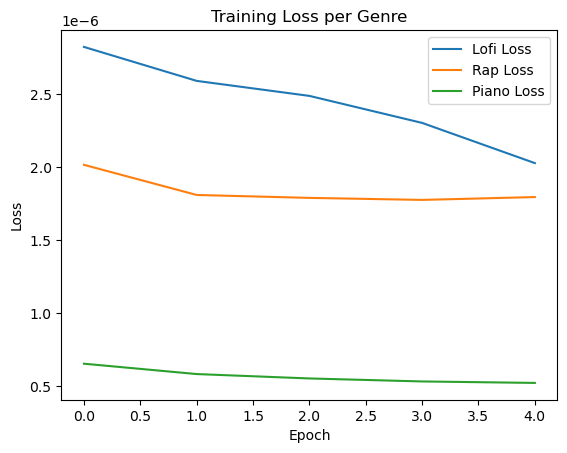

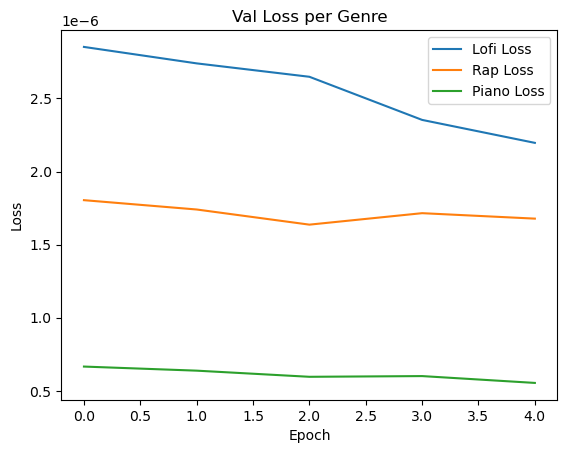

In [12]:
num_epochs = 5
lofi_train_losses, lofi_val_losses = train_network(model, lofi_train_loader, lofi_val_loader, criterion, optimizer, num_epochs)
piano_train_losses, piano_val_losses = train_network(model, piano_train_loader, piano_val_loader, criterion, optimizer, num_epochs)
rap_train_losses, rap_val_losses = train_network(model, rap_train_loader, rap_val_loader, criterion, optimizer, num_epochs)

plot_genre_losses(lofi_train_losses, piano_train_losses, rap_train_losses, "Training Loss per Genre")
plot_genre_losses(lofi_val_losses, piano_val_losses, rap_val_losses, "Val Loss per Genre")


In [19]:
def generate_sample_output(model, input_samples, sample_length):
    
    model.eval().to(device)
    input_samples = input_samples.to(device)
    input_sequence = input_samples.clone().float()
    gen_samples = []
    
    with torch.no_grad():
        
        for i in range(sample_length):
            if i % 10000 == 0:
                print(i)
                
            output = model(input_sequence)
            val = output[0,-1]
            val = torch.tensor([[val]]).to(device)
            
            gen_samples.append(output.squeeze()[-1].item())
            
            input_sequence = input_sequence[:, 1:]
            
            input_sequence = torch.cat((input_sequence, val), dim=1) 

    return gen_samples
    
sample_length = 80000
 

In [15]:
lofi_samples, target_data = lofi_test_dataset[0]
lofi_samples = lofi_samples.unsqueeze(0)
lofi_ouput = generate_sample_output(model, lofi_samples, sample_length)

0


In [20]:
piano_samples, target_data = piano_test_dataset[0]
piano_samples = piano_samples.unsqueeze(0)
piano_ouput = generate_sample_output(model, piano_samples, sample_length)

0
10000
20000
30000
40000
50000
60000
70000


In [21]:
rap_samples, target_data = rap_test_dataset[0]
rap_samples = rap_samples.unsqueeze(0)
rap_output = generate_sample_output(model, rap_samples, sample_length)

0
10000
20000
30000
40000
50000
60000
70000


In [22]:
Audio(np.array(lofi_ouput), rate = 8000)


Text(0.5, 1.0, 'Lofi Waveform')

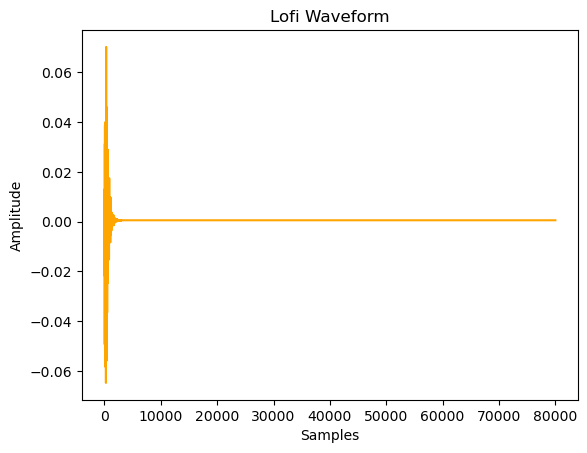

In [23]:
plt.plot(lofi_ouput, color = 'orange')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Lofi Waveform")

In [24]:
Audio(np.array(piano_ouput), rate = 8000)

Text(0.5, 1.0, 'Piano Waveform')

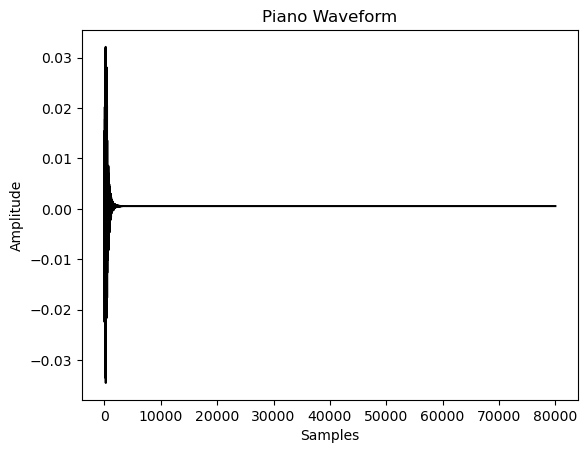

In [25]:
plt.plot(piano_ouput, color = 'black')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Piano Waveform")

In [26]:
Audio(np.array(rap_output), rate = 8000)

Text(0.5, 1.0, 'Rap Waveform')

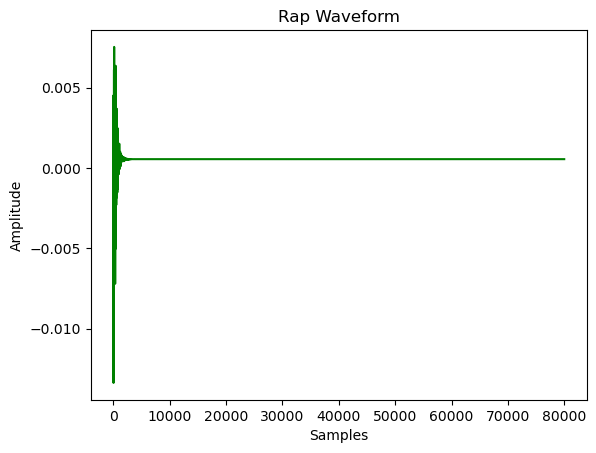

In [27]:
plt.plot(rap_output, color = 'green')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Rap Waveform")